# Data Analysis
### Predictive modelling of stroke occurences

Import libraries

In [161]:
import pandas as pd
from utils import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

Load data

In [162]:
data_loader = DataLoader("healthcare-dataset-stroke-data.csv")
data_loader.load_dataset()

# Preprocess data
- Using the preprocessing pipeline from Utils based on the findings from the data exploration 
- Oversample to account for the imbalance in the data set

In [163]:
data_loader.preprocess_data()
# Split the data for testing and training
X_train, X_test, y_train, y_test, X_val, y_val = data_loader.get_data_split()
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

# Oversample the train data 
X_train, y_train = data_loader.oversample(X_train, y_train)
print("After oversampling:", X_train.shape)

(4087, 20)
(2043, 20)
(2044, 20)
After oversampling: (7778, 20)


In [164]:
X_train

,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,40.0,0.0,0.0,153.24,38.2
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,63.0,0.0,0.0,248.37,32.2
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,27.0,0.0,0.0,226.75,28.9
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,39.0,0.0,0.0,82.85,22.9
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,42.0,0.0,0.0,108.96,27.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7773,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,69.0,0.0,0.0,82.81,28.0
7774,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,63.0,0.0,0.0,90.90,28.1
7775,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,80.0,0.0,0.0,104.12,23.5
7776,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,66.0,0.0,0.0,76.46,21.2


## Fit models
- ANN
- Random Forest
- XGBoost

### ANN

In [165]:
#Scale and Fit the data
# Scaling is needed which it is not for random forest or XGBoost
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [166]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# For reproducebility
tf.random.set_seed(2)

In [192]:
#ANN MODEL
model = Sequential()

model.add(Dense(units = 14, activation = 'relu'))
model.add(Dropout(.3))
model.add(Dense(units = 7, activation = 'relu'))
model.add(Dropout(.3))
model.add(Dense(units = 3, activation = 'relu'))
model.add(Dropout(.3))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy') # adam or SGD

In [193]:
#stops when validation loss is not dropping for 3 epochs
#early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 1)
# Rule of thumb, patience is 10% of the number of epochs 
# We need to save the model 
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [194]:
#Fitting model
model.fit(X_train, y_train, 
          epochs = 150,
         validation_data=(X_val, y_val),
         verbose = 1, 
         callbacks=callbacks, batch_size=30)

Epoch 1/150
260/260 [==============================] - 2s 4ms/step - loss: 0.6832 - accuracy: 0.5360 - val_loss: 0.6173 - val_accuracy: 0.3816
Epoch 2/150
260/260 [==============================] - 1s 3ms/step - loss: 0.6541 - accuracy: 0.5926 - val_loss: 0.5935 - val_accuracy: 0.4354
Epoch 3/150
260/260 [==============================] - 1s 3ms/step - loss: 0.6328 - accuracy: 0.6233 - val_loss: 0.5490 - val_accuracy: 0.6111
Epoch 4/150
260/260 [==============================] - 1s 3ms/step - loss: 0.5919 - accuracy: 0.6857 - val_loss: 0.4615 - val_accuracy: 0.6654
Epoch 5/150
260/260 [==============================] - 1s 3ms/step - loss: 0.5850 - accuracy: 0.6998 - val_loss: 0.4410 - val_accuracy: 0.6859
Epoch 6/150
260/260 [==============================] - 1s 2ms/step - loss: 0.5661 - accuracy: 0.7137 - val_loss: 0.4529 - val_accuracy: 0.6737
Epoch 7/150
260/260 [==============================] - 1s 2ms/step - loss: 0.5433 - accuracy: 0.7287 - val_loss: 0.4681 - val_accuracy: 0.7016

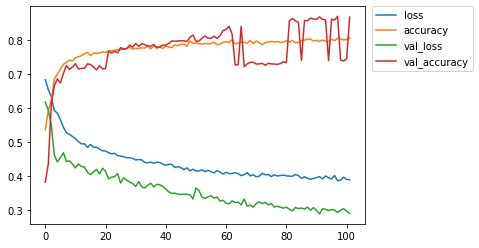

In [195]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [196]:
from keras.models import load_model
saved_model = load_model('best_model.h5')

#Predictions
prediction_values = saved_model.predict(X_test)
# Convert into classes 
prediction_best = []
for i in prediction_values:
    prediction_best.append(np.where(i > 0.5, 1,0)[0])

print(f"F1 Score {f1_score(y_test, prediction_best, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, prediction_best)}")

64/64 [==============================] - 0s 2ms/step
F1 Score 0.6537940124270383
Accuracy 0.8590308370044053


In [197]:
#Predictions
prediction_values = model.predict(X_test)
# Convert into classes 
prediction = []
for i in prediction_values:
    prediction.append(np.where(i > 0.5, 1,0)[0])
    

64/64 [==============================] - 0s 2ms/step


In [198]:
# Prediction on the last model not the best
print(f"F1 Score {f1_score(y_test, prediction, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, prediction)}")

F1 Score 0.6545087068133688
Accuracy 0.8585413607440039


In [199]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,prediction_best))
print()
cf = confusion_matrix(y_test,prediction_best)
print(cf)

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1935
           1       0.25      0.84      0.39       108

    accuracy                           0.86      2043
   macro avg       0.62      0.85      0.65      2043
weighted avg       0.95      0.86      0.89      2043


[[1664  271]
 [  17   91]]


<AxesSubplot:>

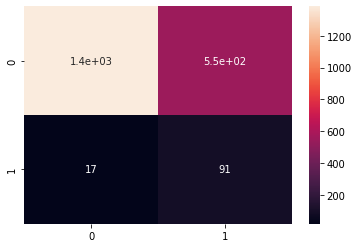

In [175]:
import seaborn as sns
sns.heatmap(cf, annot=True)

### XGBoost

In [176]:
from xgboost import XGBClassifier
XGB = XGBClassifier(eval_metric= 'error')
XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test,y_pred))
print()
cf = confusion_matrix(y_test,y_pred)
print(cf)

F1 Score 0.9788344988344989
Accuracy 0.9955947136563876
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1935
           1       0.92      1.00      0.96       108

    accuracy                           1.00      2043
   macro avg       0.96      1.00      0.98      2043
weighted avg       1.00      1.00      1.00      2043


[[1926    9]
 [   0  108]]


<AxesSubplot:>

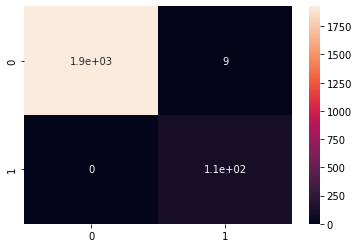

In [177]:
sns.heatmap(cf, annot = True)

### Random Forest

In [178]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test,y_pred))
print()
cf = confusion_matrix(y_test,y_pred)

F1 Score 1.0
Accuracy 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1935
           1       1.00      1.00      1.00       108

    accuracy                           1.00      2043
   macro avg       1.00      1.00      1.00      2043
weighted avg       1.00      1.00      1.00      2043




<AxesSubplot:>

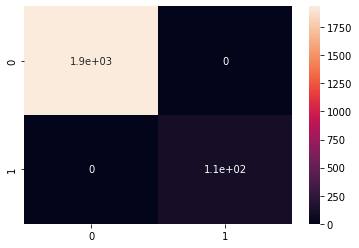

In [179]:
sns.heatmap(cf, annot = True)